In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
from PIL import Image
import time
import matplotlib.pyplot as plt
import pickle

import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
from torch.utils.data import Dataset

import argparse
import torch
# import torch.tensor as tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import time
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.autograd import Variable
from sklearn.metrics import average_precision_score

from torchvision import models
#from resnet import resnet50
#from res2net import res2net50_48w_2s,res2net50_26w_8s,res2net50

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
#from resnet import resnet50


In [2]:
def tensor(x):
    return torch.tensor(x)

In [7]:
import sys
print(sys.path)

['D:\\desktop2\\new start learning', 'D:\\Anaconda\\envs\\CVenv\\python37.zip', 'D:\\Anaconda\\envs\\CVenv\\DLLs', 'D:\\Anaconda\\envs\\CVenv\\lib', 'D:\\Anaconda\\envs\\CVenv', '', 'C:\\Users\\王事\\AppData\\Roaming\\Python\\Python37\\site-packages', 'D:\\Anaconda\\envs\\CVenv\\lib\\site-packages', 'D:\\Anaconda\\envs\\CVenv\\lib\\site-packages\\win32', 'D:\\Anaconda\\envs\\CVenv\\lib\\site-packages\\win32\\lib', 'D:\\Anaconda\\envs\\CVenv\\lib\\site-packages\\Pythonwin', 'D:\\Anaconda\\envs\\CVenv\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\王事\\.ipython']


In [10]:
with open('D:\\desktop2\\new start learning\cuhksz learning\capstone\huawei project-workspace\capstone-SEprediction\DataSet_2021_8_5_filter_combine_normalize.pkl', 'rb') as f:
    X_train,y_train,X_val,y_val,X_test,y_test,y_max = pickle.load(f)

In [11]:
print(X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape)

(1352314, 47) (1352314, 2) (29142, 47) (29142, 2) (128232, 47) (128232, 2)


In [12]:
def y2label(y_ori,y_max):
    labels = np.zeros(y_ori.shape).astype(np.int32)+3
    
    labels[y_ori*y_max <= 3000] = 2
    labels[y_ori*y_max <= 2000] = 1
    labels[y_ori*y_max <= 1000] = 0
    
    return labels

In [13]:
X_train = X_train[:,0:34]
y_train = y_train[:,0]
X_val = X_val[:,0:34]
y_val = y_val[:,0]
X_test = X_test[:,0:34]
y_test = y_test[:,0]
ylabel_train = y2label(y_train,y_max[0])
ylabel_val = y2label(y_val,y_max[0])
ylabel_test = y2label(y_test,y_max[0])

In [ ]:
counts = [sum(ylabel_train == 0),sum(ylabel_train == 1),sum(ylabel_train == 2),sum(ylabel_train == 3)]

<BarContainer object of 4 artists>

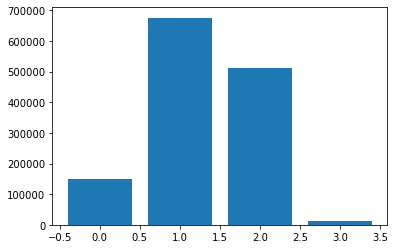

In [32]:
plt.bar(range(len(counts)),counts)

In [14]:
class Train_Dataset(Dataset):
    def __init__(self, path="DataSet_2021_8_5_filter_combine_normalize.pkl",transform=None, target_transform=None):
        
        with open('DataSet_2021_8_5_filter_combine_normalize.pkl', 'rb') as f:
            X_train,y_train,X_val,y_val,X_test,y_test,y_max = pickle.load(f)
        
        self.X_train = X_train[:,0:34]
        self.y_train = y_train[:,0]
        
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.X_train.shape[0]

    def __getitem__(self, idx):
        
        #image = torchvision.transforms.functional.to_tensor(np.array(image.resize((240,320),Image.BILINEAR)))
        #label = tensor(self.label2vec(label))
        
        x_train = tensor(self.X_train[idx,:])
        label = tensor(self.y_train[idx])
    
        return x_train,label

class Val_Dataset(Dataset):
    def __init__(self, path="DataSet_2021_8_5_filter_combine_normalize.pkl",transform=None, target_transform=None):
        
        with open('DataSet_2021_8_5_filter_combine_normalize.pkl', 'rb') as f:
            X_train,y_train,X_val,y_val,X_test,y_test,y_max = pickle.load(f)
        
        self.X_val = X_val[:,0:34]
        self.y_val = y_val[:,0]
        
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.X_val.shape[0]

    def __getitem__(self, idx):
        
        #image = torchvision.transforms.functional.to_tensor(np.array(image.resize((240,320),Image.BILINEAR)))
        #label = tensor(self.label2vec(label))
        
        x_val = tensor(self.X_val[idx,:])
        label = tensor(self.y_val[idx])
    
        return x_val,label

class Test_Dataset(Dataset):
    def __init__(self, path="DataSet_2021_8_5_filter_combine_normalize.pkl",transform=None, target_transform=None):
        
        with open('DataSet_2021_8_5_filter_combine_normalize.pkl', 'rb') as f:
            X_train,y_train,X_val,y_val,X_test,y_test,y_max = pickle.load(f)
        
        self.X_test = X_test[:,0:34]
        self.y_test = y_test[:,0]
        
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.X_test.shape[0]

    def __getitem__(self, idx):
        
        #image = torchvision.transforms.functional.to_tensor(np.array(image.resize((240,320),Image.BILINEAR)))
        #label = tensor(self.label2vec(label))
        
        x_test = tensor(self.X_test[idx,:])
        label = tensor(self.y_test[idx])
    
        return x_test,label

In [15]:
class Train_Label_Dataset(Dataset):
    def __init__(self, path="DataSet_2021_8_5_filter_combine_normalize.pkl",transform=None, target_transform=None):
        
        with open('DataSet_2021_8_5_filter_combine_normalize.pkl', 'rb') as f:
            X_train,y_train,X_val,y_val,X_test,y_test,y_max = pickle.load(f)
        
        self.X_train = X_train[:,0:34]
        self.y_train = y2label(y_train[:,0],y_max[0])
        
        
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.X_train.shape[0]

    def __getitem__(self, idx):
        
        #image = torchvision.transforms.functional.to_tensor(np.array(image.resize((240,320),Image.BILINEAR)))
        #label = tensor(self.label2vec(label))
        
        x_train = tensor(self.X_train[idx,:])
        label = tensor(self.y_train[idx])
    
        return x_train,label

class Val_Label_Dataset(Dataset):
    def __init__(self, path="DataSet_2021_8_5_filter_combine_normalize.pkl",transform=None, target_transform=None):
        
        with open('DataSet_2021_8_5_filter_combine_normalize.pkl', 'rb') as f:
            X_train,y_train,X_val,y_val,X_test,y_test,y_max = pickle.load(f)
        
        self.X_val = X_val[:,0:34]
        self.y_val = y2label(y_val[:,0],y_max[0])
        
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.X_val.shape[0]

    def __getitem__(self, idx):
        
        #image = torchvision.transforms.functional.to_tensor(np.array(image.resize((240,320),Image.BILINEAR)))
        #label = tensor(self.label2vec(label))
        
        x_val = tensor(self.X_val[idx,:])
        label = tensor(self.y_val[idx])
    
        return x_val,label

class Test_Label_Dataset(Dataset):
    def __init__(self, path="DataSet_2021_8_5_filter_combine_normalize.pkl",transform=None, target_transform=None):
        
        with open('DataSet_2021_8_5_filter_combine_normalize.pkl', 'rb') as f:
            X_train,y_train,X_val,y_val,X_test,y_test,y_max = pickle.load(f)
        
        self.X_test = X_test[:,0:34]
        self.y_test = y2label(y_test[:,0],y_max[0])
        
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.X_test.shape[0]

    def __getitem__(self, idx):
        
        #image = torchvision.transforms.functional.to_tensor(np.array(image.resize((240,320),Image.BILINEAR)))
        #label = tensor(self.label2vec(label))
        
        x_test = tensor(self.X_test[idx,:])
        label = tensor(self.y_test[idx])
    
        return x_test,label

In [16]:
def train_classifier(train_loader, classifier, criterion, optimizer,show_interval = 3000):
    classifier.train()
    loss_ = 0.0
    losses = []
    acc = []
    for i, (images, labels) in enumerate(train_loader):
        labels = torch.tensor(np.array(labels))
        images, labels = images.to(torch.float32).to(device), labels.to(torch.int64).to(device)
        
        logits = classifier(images)
        loss = criterion(logits,labels)
        loss = loss.requires_grad_()
        
        if i % show_interval == 0:
            print(i*args.batch_size)
            acc_new = acc_cal(logits.detach(),labels)
            acc += [acc_new]
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.detach())
        
    return torch.stack(losses).mean().item(),np.mean(acc)
    
def test_classifier(test_loader, classifier, criterion, print_ind_classes=True):
    classifier.eval()
    losses = []
    acc = []
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            labels = torch.tensor(np.array(labels))
            images, labels = images.to(torch.float32).to(device), labels.to(torch.int64).to(device)

            logits = classifier(images)
            acc_new = acc_cal(logits,labels)
            acc += [acc_new]
            
            loss = criterion(logits,labels)
            losses.append(loss.detach())
        
        test_loss = torch.stack(losses).mean().item()
    return test_loss,np.mean(acc)

def acc_cal(logits,labels,show = False):
    pred_labels = np.argmax(logits,1)
    pred_flags = pred_labels == labels
    acc = np.sum(pred_flags.numpy())/pred_labels.shape[0]
    if(show):
        print(pred_labels)
    return acc

### Hyper Parameters Settings

In [17]:
class paras():
    def __init__(self):
        self.batch_size = None
        self.classes = None

In [18]:
args = paras()
args.batch_size = 128
#args.classes = 20

### Dataloader Initial

In [21]:
train_dataset = Train_Dataset()
val_dataset = Val_Dataset()
test_dataset = Test_Dataset()

train_label_dataset = Train_Label_Dataset()
val_label_dataset = Val_Label_Dataset()
test_label_dataset = Test_Label_Dataset()

In [22]:
train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=True)

In [23]:
train_label_dataloader = DataLoader(train_label_dataset, batch_size=args.batch_size, shuffle=False)
val_label_dataloader = DataLoader(val_label_dataset, batch_size=args.batch_size, shuffle=True)
test_label_dataloader = DataLoader(test_label_dataset, batch_size=args.batch_size, shuffle=True)

### Model Initialize

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
class MLP_BN(nn.Module):
    def __init__(self, input_size,output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 2*input_size)
        nn.init.kaiming_normal_(self.fc1.weight)
        self.BN1 = nn.BatchNorm1d(2*input_size)
        
        self.fc2 = nn.Linear(2*input_size, 4*input_size)
        nn.init.kaiming_normal_(self.fc2.weight)
        self.BN2 = nn.BatchNorm1d(4*input_size)
        
        
        self.fc3 = nn.Linear(4*input_size, input_size)
        nn.init.kaiming_normal_(self.fc3.weight)
        self.BN3 = nn.BatchNorm1d(input_size)
        
        self.fc4 = nn.Linear(input_size, 8)
        nn.init.kaiming_normal_(self.fc4.weight)
        self.BN4 = nn.BatchNorm1d(8)
        
        self.fc5 = nn.Linear(8, output_size)
        nn.init.kaiming_normal_(self.fc5.weight)
        
        
    
    def forward(self, x):
        # forward always defines connectivity
        #x = flatten(x)
        #scores = self.fc2(F.relu(self.fc1(x)))
        #print(x.shape)
        x = torch.tensor(x).to(torch.float32)
        x = self.BN1(F.relu(self.fc1(x)))
        x = self.BN2(F.relu(self.fc2(x)))
        x = self.BN3(F.relu(self.fc3(x)))
        x = self.BN4(F.relu(self.fc4(x)))
        x = F.relu(self.fc5(x))
        
        return x
    
class DeepMLP(nn.Module):
    def __init__(self, input_size,output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 2*input_size)
        nn.init.kaiming_normal_(self.fc1.weight)
        
        self.fc2 = nn.Linear(2*input_size, 4*input_size)
        nn.init.kaiming_normal_(self.fc2.weight)
        
        self.fc3 = nn.Linear(4*input_size, 8*input_size)
        nn.init.kaiming_normal_(self.fc3.weight)
        
        self.fc4 = nn.Linear(8*input_size, input_size)
        nn.init.kaiming_normal_(self.fc4.weight)
        
        self.fc5 = nn.Linear(input_size, input_size//4)
        nn.init.kaiming_normal_(self.fc5.weight)
        
        self.fc6 = nn.Linear(input_size//4, output_size)
        nn.init.kaiming_normal_(self.fc6.weight)
        
    
    def forward(self, x):
        # forward always defines connectivity
        #x = flatten(x)
        #scores = self.fc2(F.relu(self.fc1(x)))
        #print(x.shape)
        x0 = torch.tensor(x).to(torch.float32)
        x = nn.LeakyReLU(0.3)(self.fc1(x0))
        x = nn.LeakyReLU(0.2)(self.fc2(x))
        x = nn.LeakyReLU(0.18)(self.fc3(x))
        
        x = nn.LeakyReLU(0.15)(self.fc4(x))+x0 #residual here
        
        x = nn.LeakyReLU(0.1)(self.fc5(x))
        x = torch.sigmoid(self.fc6(x))
        
        return x    
class TestMLP(nn.Module):
    def __init__(self, input_size,output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 2*input_size)
        nn.init.kaiming_normal_(self.fc1.weight)
        
        self.fc2 = nn.Linear(2*input_size, 4*input_size)
        nn.init.kaiming_normal_(self.fc2.weight)
        
        self.fc3 = nn.Linear(4*input_size, input_size)
        nn.init.kaiming_normal_(self.fc3.weight)
        
        self.fc4 = nn.Linear(input_size, 8)
        nn.init.kaiming_normal_(self.fc4.weight)
        
        self.fc5 = nn.Linear(8, output_size)
        nn.init.kaiming_normal_(self.fc5.weight)
        
        
    
    def forward(self, x):
        # forward always defines connectivity
        #x = flatten(x)
        #scores = self.fc2(F.relu(self.fc1(x)))
        #print(x.shape)
        x = torch.tensor(x).to(torch.float32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        
        return x

model = DeepMLP(X_train.shape[1],1)
classifier = model.to(device)

criterion = torch.nn.L1Loss()
criterion = criterion.to(device)

In [26]:
# label classifier model
model = TestMLP(X_train.shape[1],4)
classifier = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)

### Optimizer Settings

In [27]:
lr = 0.001
moment = 0.8
epoch_sum = 0

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, classifier.parameters()), lr=lr)
# optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, classifier.parameters()), lr=lr, momentum=moment)

In [28]:
if epoch_sum == 0:
    train_loss_list = []
    val_loss_list = []
    val_f1_list = []
    time_list = []

In [29]:
# Train the Label Classifier Model
NUM_EPOCHS = 5
TEST_FREQUENCY = 1
time_start = time.time()
for epoch in range(1, NUM_EPOCHS+1):
    time_epoch_start = time.time()
    print("Starting epoch number " + str(epoch_sum))
    train_loss = train_classifier(train_label_dataloader, classifier, criterion, optimizer)
    train_loss_list += [train_loss]
    print("Loss for Training on Epoch " +str(epoch_sum) + " is "+ str(train_loss))
    
    #plt.plot(train_loss_list)
    time_epoch_end = time.time()
    time_one_epoch = time_epoch_end - time_epoch_start
    time_list += [time_one_epoch]
    print("Time for epoch {} is {}".format(epoch_sum,time_one_epoch))
    
    
    if(epoch_sum%TEST_FREQUENCY==0):
        val_loss= test_classifier(val_label_dataloader, classifier, criterion)
        val_loss_list += [val_loss]
        print('Evaluating classifier')
        print("Loss for validation on Epoch"+str(epoch_sum)+" is "+str(val_loss))
    
    epoch_sum += 1
    
    
    

Starting epoch number 0
0


D:\Anaconda\envs\CVenv\lib\site-packages\ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


384000
768000
1152000
Loss for Training on Epoch 0 is (0.5740236043930054, 0.720703125)
Time for epoch 0 is 64.47961521148682
Evaluating classifier
Loss for validation on Epoch0 is (0.45661839842796326, 0.8116513349143206)
Starting epoch number 1
0
384000
768000
1152000
Loss for Training on Epoch 1 is (0.3839298486709595, 0.978515625)
Time for epoch 1 is 70.31831955909729
Evaluating classifier
Loss for validation on Epoch1 is (0.4440048635005951, 0.8168923398612811)
Starting epoch number 2
0
384000
768000
1152000
Loss for Training on Epoch 2 is (0.36906948685646057, 0.978515625)
Time for epoch 2 is 70.26450967788696
Evaluating classifier
Loss for validation on Epoch2 is (0.40066736936569214, 0.8439436390758874)
Starting epoch number 3
0
384000
768000
1152000
Loss for Training on Epoch 3 is (0.36219194531440735, 0.970703125)
Time for epoch 3 is 66.93599700927734
Evaluating classifier
Loss for validation on Epoch3 is (0.3683343529701233, 0.8581127600979191)
Starting epoch number 4
0
3840

In [31]:
torch.save(model,"label_classifier.pt")

Starting epoch number 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0
384000
768000
1152000


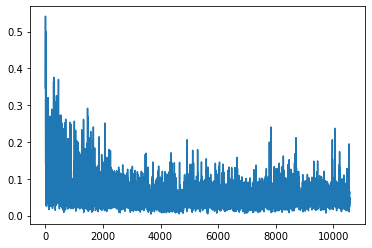

Loss for Training on Epoch 0 is 0.05658872425556183
Time for epoch 0 is 64.68477749824524
Evaluating classifier
Loss for validation on Epoch0 is 0.04390736669301987
Starting epoch number 1
0
384000
768000
1152000


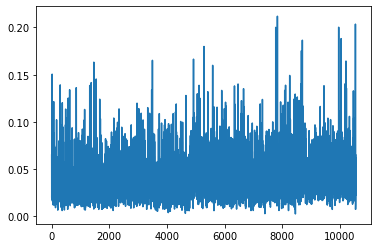

Loss for Training on Epoch 1 is 0.04024404287338257
Time for epoch 1 is 64.15565657615662
Evaluating classifier
Loss for validation on Epoch1 is 0.04367026686668396
Starting epoch number 2
0
384000
768000
1152000


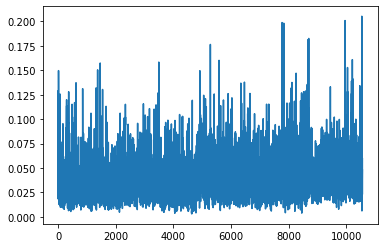

Loss for Training on Epoch 2 is 0.038811322301626205
Time for epoch 2 is 63.73570156097412
Evaluating classifier
Loss for validation on Epoch2 is 0.04307570308446884
Starting epoch number 3
0
384000
768000
1152000


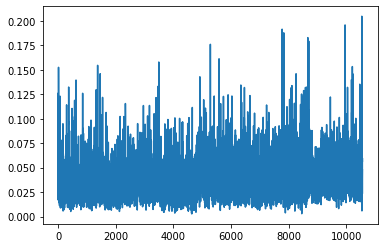

Loss for Training on Epoch 3 is 0.03812848776578903
Time for epoch 3 is 63.73891830444336
Evaluating classifier
Loss for validation on Epoch3 is 0.04185357317328453
Starting epoch number 4
0
384000
768000
1152000


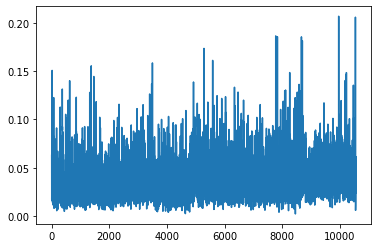

Loss for Training on Epoch 4 is 0.037698905915021896
Time for epoch 4 is 64.55167841911316
Evaluating classifier
Loss for validation on Epoch4 is 0.041122011840343475


In [24]:
# Train the Classifier Model
NUM_EPOCHS = 5
TEST_FREQUENCY = 1
time_start = time.time()
for epoch in range(1, NUM_EPOCHS+1):
    time_epoch_start = time.time()
    print("Starting epoch number " + str(epoch_sum))
    train_loss = train_classifier(train_dataloader, classifier, criterion, optimizer)
    train_loss_list += [train_loss]
    print("Loss for Training on Epoch " +str(epoch_sum) + " is "+ str(train_loss))
    
    #plt.plot(train_loss_list)
    time_epoch_end = time.time()
    time_one_epoch = time_epoch_end - time_epoch_start
    time_list += [time_one_epoch]
    print("Time for epoch {} is {}".format(epoch_sum,time_one_epoch))
    
    
    if(epoch_sum%TEST_FREQUENCY==0):
        val_loss= test_classifier(val_dataloader, classifier, criterion)
        val_loss_list += [val_loss]
        print('Evaluating classifier')
        print("Loss for validation on Epoch"+str(epoch_sum)+" is "+str(val_loss))
    
    epoch_sum += 1
    
    
    

Text(0.5, 1.0, 'Loss Curve')

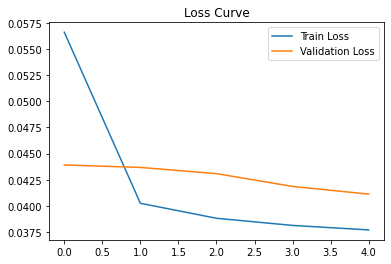

In [25]:
plt.plot(train_loss_list,label="Train Loss")
plt.plot(val_loss_list,label="Validation Loss")

plt.legend()
plt.title("Loss Curve")

In [111]:
#torch.save(classifier,"Only_MLP_"+"epoch{}.pt".format(epoch_sum))

### Predict with test dataset

In [1]:
def predict_se(model, X_test, y_test, dataset_SE_max, plot=True):
    print("[INFO] predicting...")
    X_test = torch.tensor(X_test).to(device)
    preds = model.forward(X_test)
    preds = preds.cpu().detach().numpy().flatten()
    y_test = y_test.flatten()
    diff = abs(preds-y_test)*dataset_SE_max
    # choose how many bins you want here
    num_bins = 30
    # use the histogram function to bin the data
    counts, bin_edges = np.histogram(diff, bins=num_bins)
    # now find the cdf
    cdf = np.cumsum(counts)
    # and finally plot the cdf
    if plot:
        plt.plot(bin_edges[1:], cdf)
        plt.xlabel('Absolute Error (Mbit/Number)')
        plt.ylabel('Count')
        plt.title('Error CDF')
        plt.show()
    diff_percen = abs(preds-y_test)/y_test
    mean = np.mean(abs(diff))
    std = np.std(diff)
    print("[INFO] error mean: {:.3f}, std: {:.3f}".format(mean, std))
    mean = np.mean(abs(diff_percen))
    std = np.std(diff_percen)
    print("[INFO] percentage error mean: {:.3f}, std: {:.3f}" .format(mean, std))
    axis_lim = y_test.mean()*dataset_SE_max*2
    # mean absolute percentage error by sections
    diff_with_y = np.hstack((y_test[:,np.newaxis]*dataset_SE_max, diff_percen[:,np.newaxis]))
    sort_indices = np.argsort(diff_with_y[:,0])
    diff_with_y = diff_with_y[sort_indices,:]
    mape_sections = np.array([1000, 1500, 2500, np.iinfo(int).max])
    mape_sections_mean = np.empty(len(mape_sections))
    idx_section = 0
    diff_id_section = 0
    for i in range(len(diff_with_y)):
        if diff_with_y[i,0]>mape_sections[idx_section] or i == len(diff_with_y)-1:
            mape_sections_mean[idx_section] = np.mean(diff_with_y[diff_id_section:i,1])
            diff_id_section = i
            idx_section = idx_section + 1
    print("[INFO] MAPE by sections: ", np.around(mape_sections_mean, decimals=2))
    if plot:
        plt.figure()
        plt.plot(preds.flatten()*dataset_SE_max, y_test*dataset_SE_max, '.')
        plt.plot([0, axis_lim], [0, axis_lim])
        plt.axis([0, axis_lim, 0, axis_lim])
        plt.xlabel('Prediction (Mbit/Number)')
        plt.ylabel('Ground Truth (Mbit/Number)')
        plt.title('Spectral Efficiency')
        plt.show()

def VisPredict(model,plotOn,X_train,y_train,X_val,y_val,X_test,y_test,dataset_SE_max):
    # make predictions on the testing data
    predict_se(model, X_train, y_train, dataset_SE_max, plotOn)
    predict_se(model, X_val, y_val, dataset_SE_max, plotOn)
    predict_se(model, X_test, y_test, dataset_SE_max, plotOn)
    if plotOn:
        dot_img_file = 'figures/model_1.png'
        #tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

### Predict Results

In [2]:
torch.cuda.empty_cache ()
VisPredict(model,True,X_train,y_train,X_val,y_val,X_test,y_test,y_max[0,0])

NameError: name 'torch' is not defined